In [1]:
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting

import jungfrau_utils as ju
from alvra_tools import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


### Location of the BSREAD file with PSSS data and the file with corrected images

In [43]:
bsread_file = "/sf/alvra/data/p17982/raw/OCP_2a_LCP_300fs_1uJ/run_000320.BSREAD.h5"
images_file = "/sf/alvra/data/p17982/res/OCP_2a_LCP_300fs_1uJ/data/dark/run_000320.JF06T08V01.h5"

### Load the PSSS data from BSREAD file using alvra_tools

In [44]:
(Energy, FWHM, X, Y, pulseID) = \
load_PSSS_data_from_scans_pulseID(bsread_file,channel_PSSS_center, 50)

### Load the images and pulse_ids of images with hits using alvra_tools

In [46]:
(Images, pulseID_img) = load_corr_JF_data(images_file)

### Filter out spectra that don't have corresponding JF images

In [47]:
X_filtered = []
Y_filtered = []
Energy_filtered = []

# find matching pulseID's
for i in range(0, len(pulseID_img)):
    for j in range(0, len(pulseID)):
        if pulseID_img[i] == pulseID[j]:
            
            X_filtered.append(X[j])
            Y_filtered.append(Y[j])
            en = float(Energy[j])
            Energy_filtered.append(en)
        

X_filtered = np.asarray(X_filtered)
Y_filtered = np.asarray(Y_filtered)
#Energy_filtered = np.asarray(Energy_filtered)

### Plot mean spectra for one run

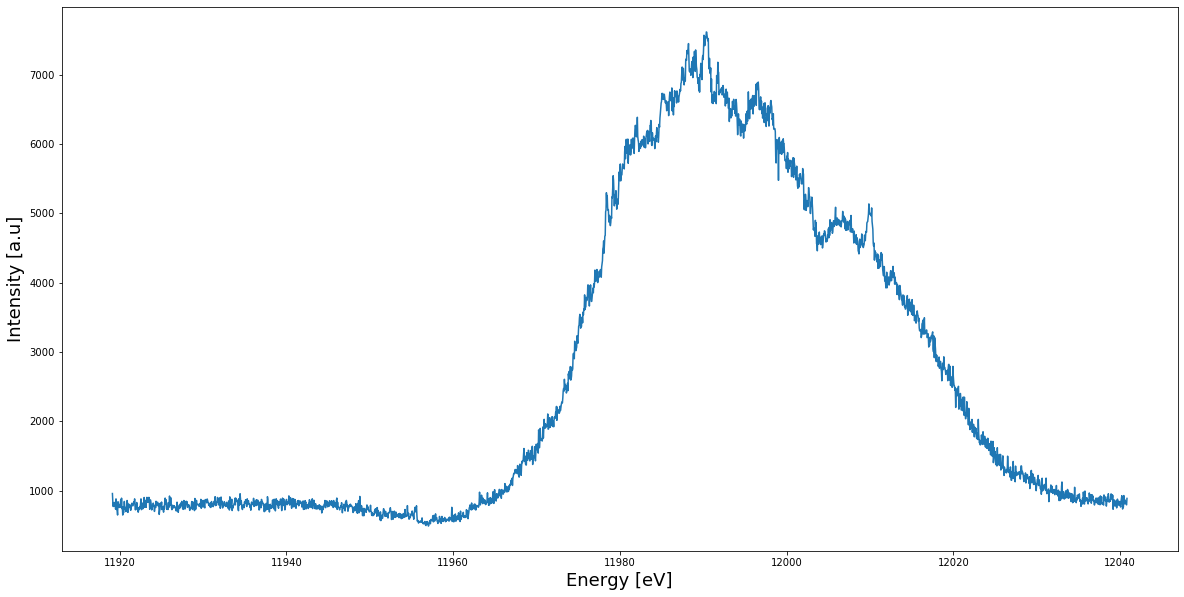

In [48]:
Y_filtered_mean = np.mean(Y_filtered, axis=0)
plt.figure(figsize=(20,10))
plt.plot(X_filtered[0], Y_filtered_mean)
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Smooth spectra

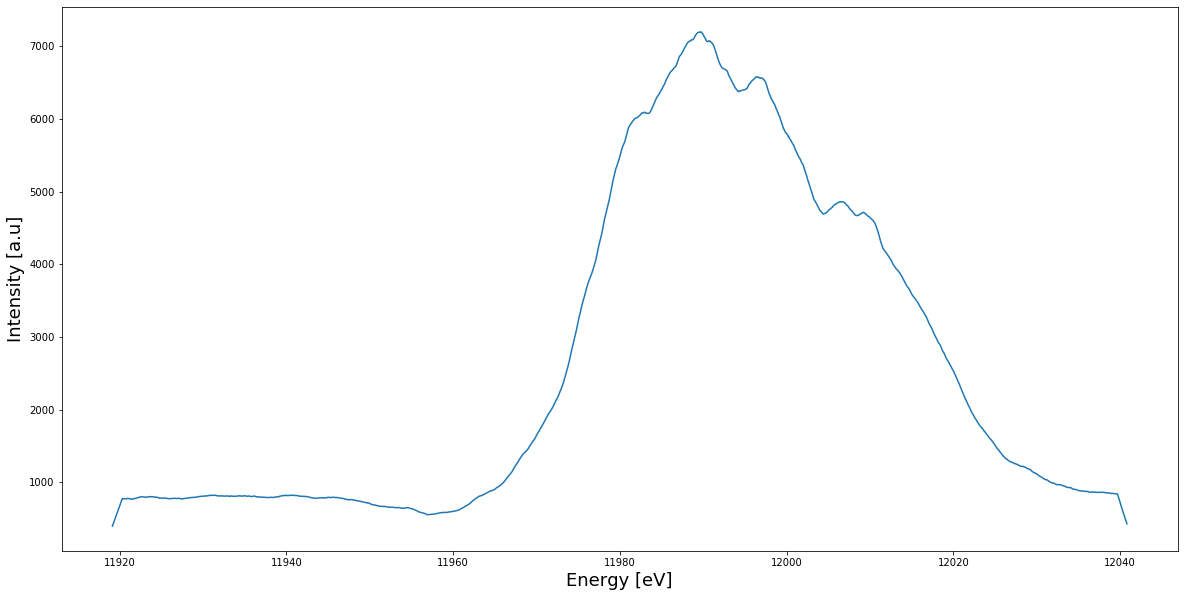

In [49]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(20,10))
plt.plot(X_filtered[0], smooth(Y_filtered_mean,50))
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.show()

### Fit the smoothed spectra with astopy

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev     
    ----------------- ------------------ -----------------
    6705.978178116179 11994.477937259908 17.29116136114782


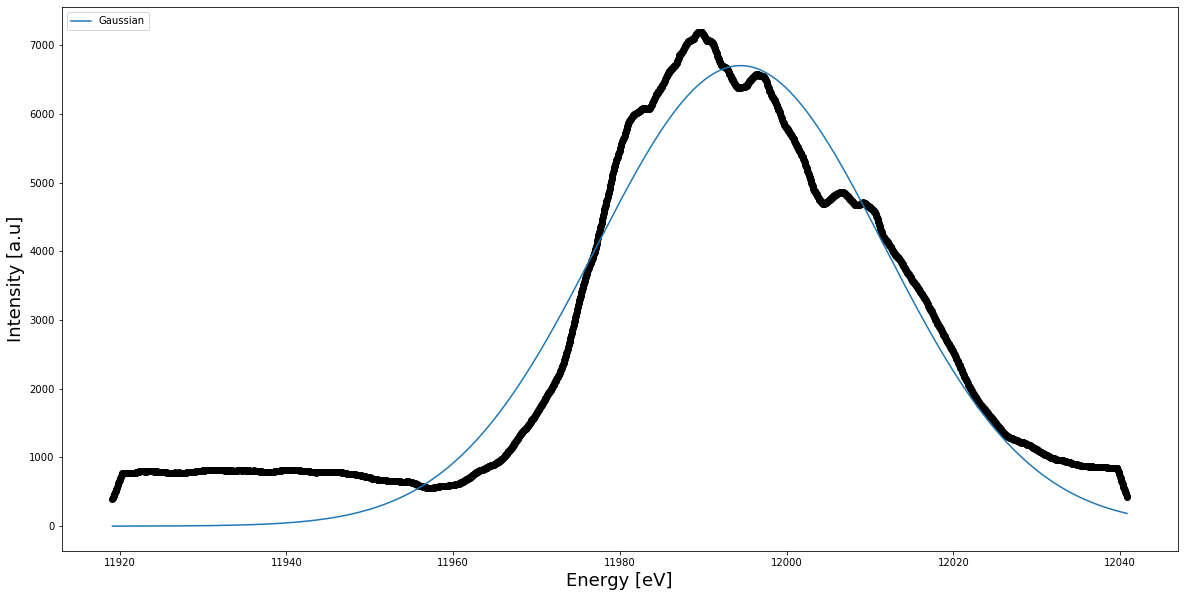

In [50]:
x = X[0]
y = smooth(Y_filtered_mean,50)

#g_init = models.Gaussian1D(amplitude=10000., mean=11210, stddev=15.)
g_init = models.Gaussian1D(amplitude=40000., mean=12000, stddev=19.)

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(20,10))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Energy [eV]', fontsize=18)
plt.ylabel('Intensity [a.u]', fontsize=18)
plt.legend(loc=2)
print(g)
#print(Energy[8])
#print(pulseID[8])